Reference https://colab.research.google.com/drive/1ZQvuAVwA3IjybezQOXnrXMGAnMyZRuPU#scrollTo=n194RcReDYfw

# Understanding semantic distance encoded in BERT

In [1]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import os
from scipy.spatial.distance import cosine
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load model and set it in eval mode

In [2]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

## Looking at tokens and their indexes with a common example

In [4]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


In [5]:
# Mark each of the 22 tokens as belonging to sentence "0".
segments_ids = [0] * len(tokenized_text)

print (segments_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

## Predict in order to obtain hidden layer weights

In [1]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

SyntaxError: invalid syntax (<ipython-input-1-9cf3f2c2be24>, line 2)

In [8]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


In [9]:
def get_layer_embeddings(encoded_layers, layer=-2):
    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(encoded_layers, dim=0) # [#layers, #batch, #tokens, #hidden_dims]
    # Remove dimension 1, the "batches". 
    token_embeddings = torch.squeeze(token_embeddings, dim=1) # [#layers, #tokens, #hidden_dims]
    # # Swap dimensions 0 and 1.
    #token_embeddings = token_embeddings.permute(1,0,2) # [#tokens, #layers, #hidden_dims]
    token_vecs = torch.squeeze(token_embeddings[layer,:,:], dim=0)
    return token_vecs # [tokens, hidden_dims]

def get_token_layer_embeddings(encoded_layers, token_id=0, layer=-2):
    token_vecs = get_layer_embeddings(encoded_layers, layer)
    return torch.squeeze(token_vecs[token_id,:], dim=0)

def get_layer_sentence_embeddings(encoded_layers, layer=-2):
    token_vecs = get_layer_embeddings(encoded_layers, layer)
    return torch.mean(token_vecs, dim=0)

def sentence2embedding(model, tokenizer, sentence, layer=-2):
    # Add the special tokens.
    marked_text = "[CLS] " + sentence + " [SEP]"
    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)
    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Mark each of the 22 tokens as belonging to sentence "0".
    segments_ids = [0] * len(tokenized_text)
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
    
    return get_layer_sentence_embeddings(encoded_layers, layer)

In [10]:
get_layer_embeddings(encoded_layers,-2).size()

torch.Size([22, 768])

In [11]:
bank_indices = [6, 10, 19]
bank_embeddings = [get_token_layer_embeddings(encoded_layers, token_id=t, layer=-2) for t in bank_indices]

In [16]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank (vault)   ", str(bank_embeddings[0][:5]))
print("bank (robber)  ", str(bank_embeddings[1][:5]))
print("(river) bank   ", str(bank_embeddings[2][:5]))

First 5 vector values for each instance of "bank".

bank (vault)    tensor([ 0.9191, -0.7992, -0.2780,  0.2982,  0.4914])
bank (robber)   tensor([ 0.8025, -0.7033, -0.2846,  0.3241,  0.3792])
(river) bank    tensor([ 0.3213, -0.2997, -0.0471, -0.1536,  0.9177])


In [19]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(bank_embeddings[1], bank_embeddings[2])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(bank_embeddings[0], bank_embeddings[1])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.95
Vector similarity for *different* meanings:  0.73


In [10]:
corpus = [
    "paid 50 dollars for grocceries.",
    "paid 10 dollars for digital electronics.",
    "earned 40 dollars refund on shoes.",
    "paid 30 dollars for apples.",
    "paid 20 dollars for headphones.",
    "socks set me back 10 dollars.",
    "made 10 dollars by watching advertisements.",
    "A man is eating a food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey."
]

In [11]:
sentence2embedding(model, tokenizer, corpus[0]).size()

torch.Size([768])

In [12]:
corpus_embeddings = [ sentence2embedding(model,tokenizer,s) for s in corpus]

In [13]:
print('similarity between "A monkey is playing drums."\n"paid 20 dollars for headphones." \n\t',
      1- cosine(corpus_embeddings[4],corpus_embeddings[-2]))

print('similarity between "A monkey is playing drums."\n"A cheetah is running behind its prey."\n\t',
      1- cosine(corpus_embeddings[-1],corpus_embeddings[-2]))

print('similarity between "made 10 dollars by watching advertisements."\n"earned 40 dollars refund on shoes."\n\t',
      1- cosine(corpus_embeddings[6],corpus_embeddings[2]))

similarity between "A monkey is playing drums."
"paid 20 dollars for headphones." 
	 0.7033663392066956
similarity between "A monkey is playing drums."
"A cheetah is running behind its prey."
	 0.7820115089416504
similarity between "made 10 dollars by watching advertisements."
"earned 40 dollars refund on shoes."
	 0.8270005583763123


In [14]:
with open('corpus_labels.txt', 'w', encoding='utf-8') as f:
    f.write("\n".join(corpus))

In [15]:
data = [c.numpy() for c in corpus_embeddings]
np.savetxt('corpus_embeddings.txt',data, delimiter='\t', fmt='%12.8f')

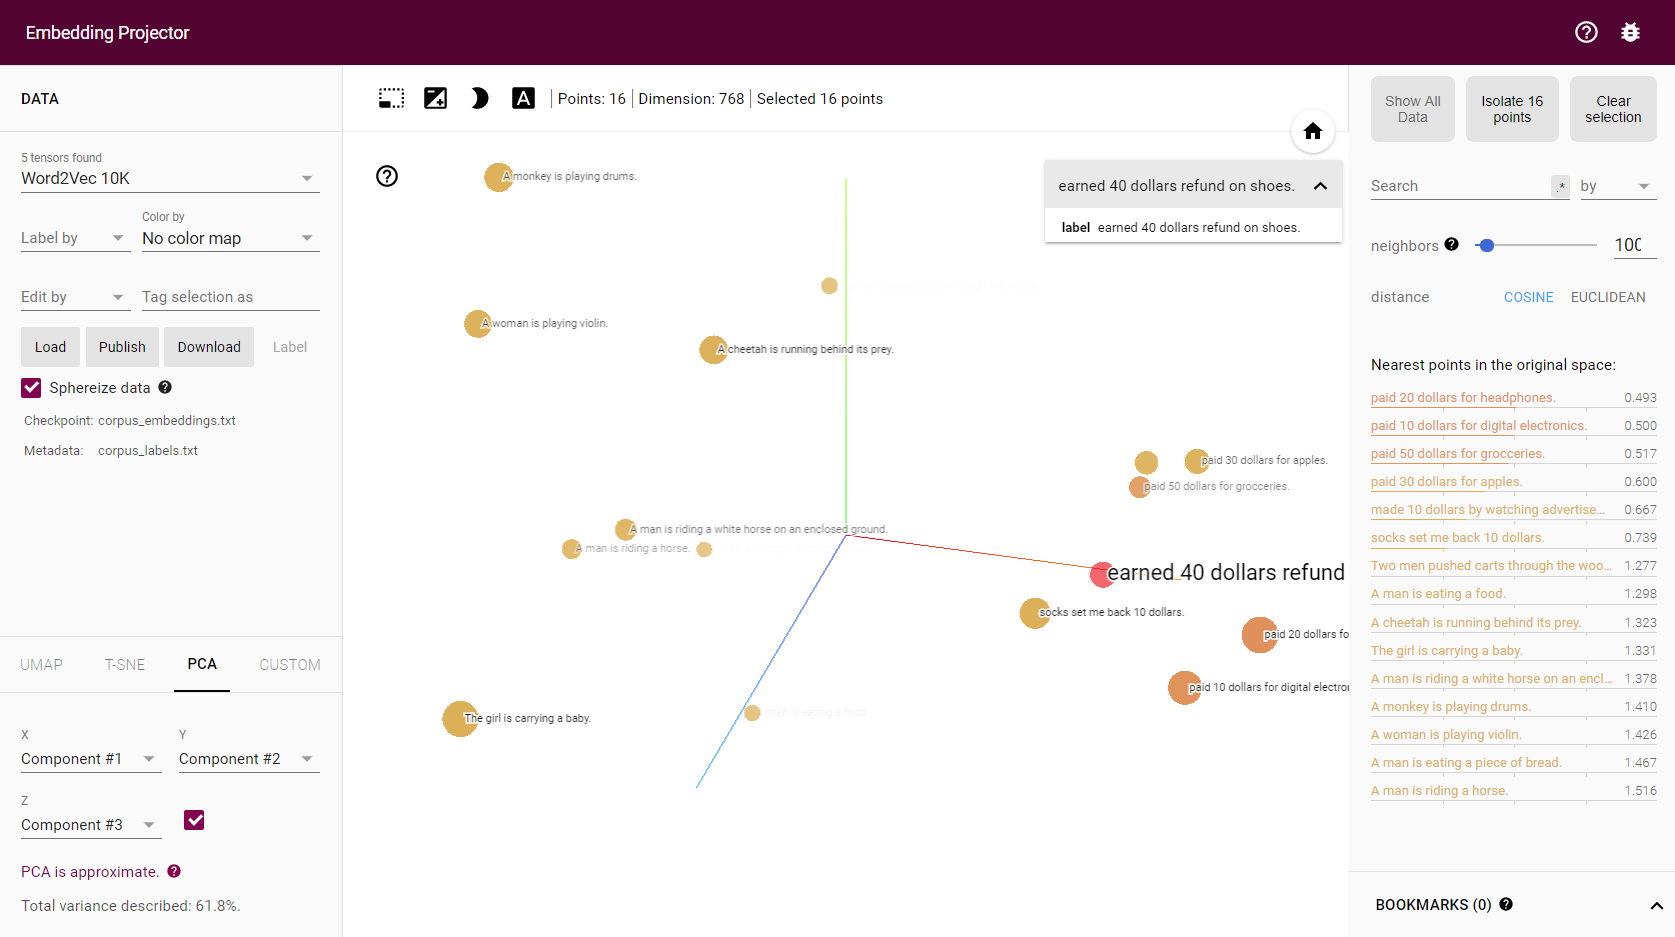